<a href="https://colab.research.google.com/github/unclepeddy/2110Pong/blob/master/6-misc-examples/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install tf-nightly-gpu-2.0-preview

%load_ext tensorboard

    100% |████████████████████████████████| 345.1MB 48kB/s 
    100% |████████████████████████████████| 61kB 24.3MB/s 
    100% |████████████████████████████████| 430kB 8.2MB/s 
    100% |████████████████████████████████| 3.1MB 8.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/89/67/41/63cbf0f6ac0a6156588b9587be4db5565f8c6d8ccef98202fc
Successfully built wrapt
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
  Found existing installation: wrapt 1.10.11
    Uninstalling wrapt-1.10.11:
      Successfully uninstalled wrapt-1.10.11


In [2]:
import datetime
import tensorflow as tf
import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os

print(tf.__version__)

2.0.0-dev20190425


In [3]:
# Download dataset
data_url = "http://data.peddy.ai/datasets/hand.tar"
data_root = tf.keras.utils.get_file("hand", data_url, untar=True)

train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test")


125444096/125440000 [==============================] - 1s 0us/step


In [13]:
# Prepare dataset to be fed into memory
target_size = (224, 224)
batch_size = 32

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    zoom_range=0.2)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_data = train_gen.flow_from_directory(train_dir, 
                                           target_size=target_size, 
                                           batch_size=batch_size,
                                           shuffle=True)
test_data = test_gen.flow_from_directory(test_dir, 
                                         target_size=target_size,
                                         batch_size=batch_size,
                                         shuffle=True)

assert train_data.num_classes == 2
assert test_data.num_classes == 2

Found 1443 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


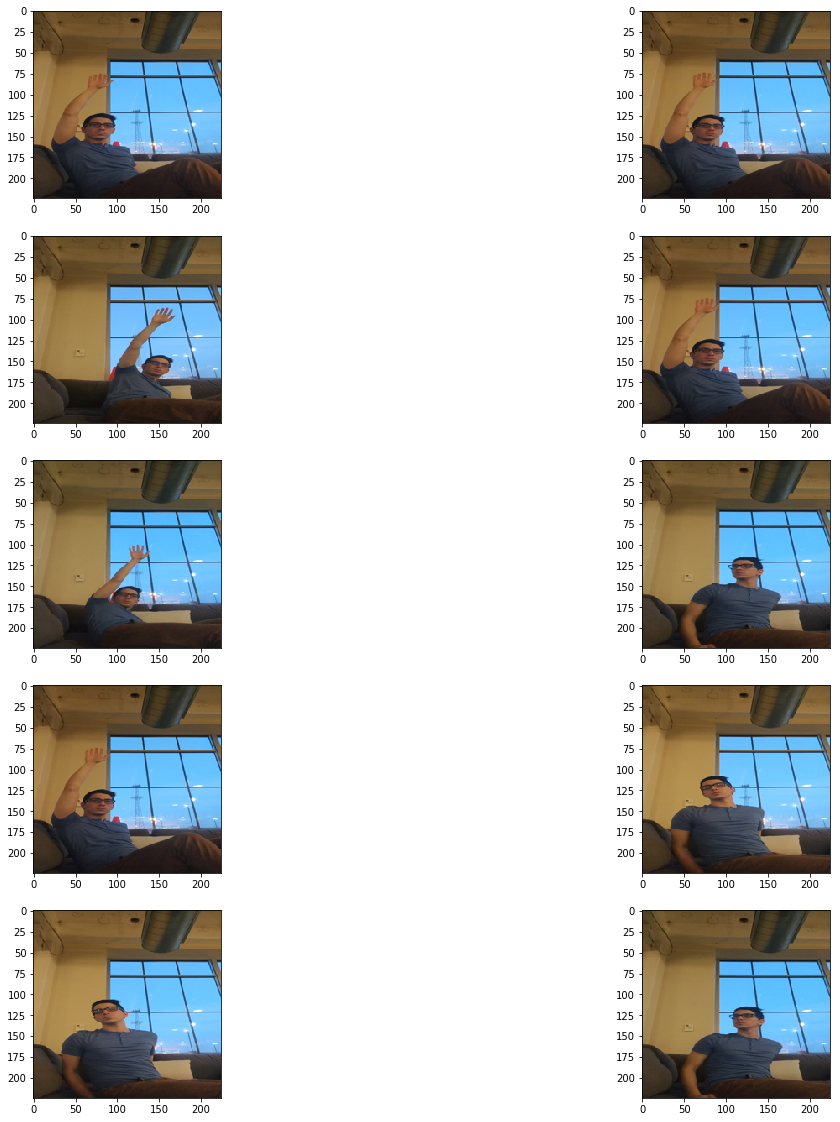

In [14]:
# Sanity check the data
sample_images, sample_targets = test_data.next()
plt.figure(figsize=(20,20))
for i in range(10):
  plt.subplot(5,2,i+1)
  plt.imshow(sample_images[i])
train_data.reset()

In [0]:
# Download hub module and create headless feature extractor
feature_extractor_url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2'
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, 
                                         input_shape=(target_size+(3,)))
feature_extractor_layer.trainable = False

In [0]:
# Attach classification head to build model
model = tf.keras.Sequential([
    feature_extractor_layer,
    tf.keras.layers.Dense(2, activation='softmax')
])

# Compile model
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

In [17]:
# Train model with appropriate telemetry 
log_dir = os.path.join('logs', datetime.datetime.now().strftime("%Y%M%d-%h%m%s"))
tb_callback = tf.keras.callbacks.TensorBoard(log_dir,
                                             histogram_freq=1,
                                             write_images=True,
                                             update_freq='batch')


steps_per_epoch = np.ceil(train_data.samples / train_data.batch_size)
model.fit(train_data,
          steps_per_epoch=steps_per_epoch,
          validation_data=test_data,
          callbacks=[tb_callback])

46/46 [==============================] - 150s 3s/step - loss: 0.4062 - acc: 0.8808 - val_loss: 0.3041 - val_acc: 0.8500


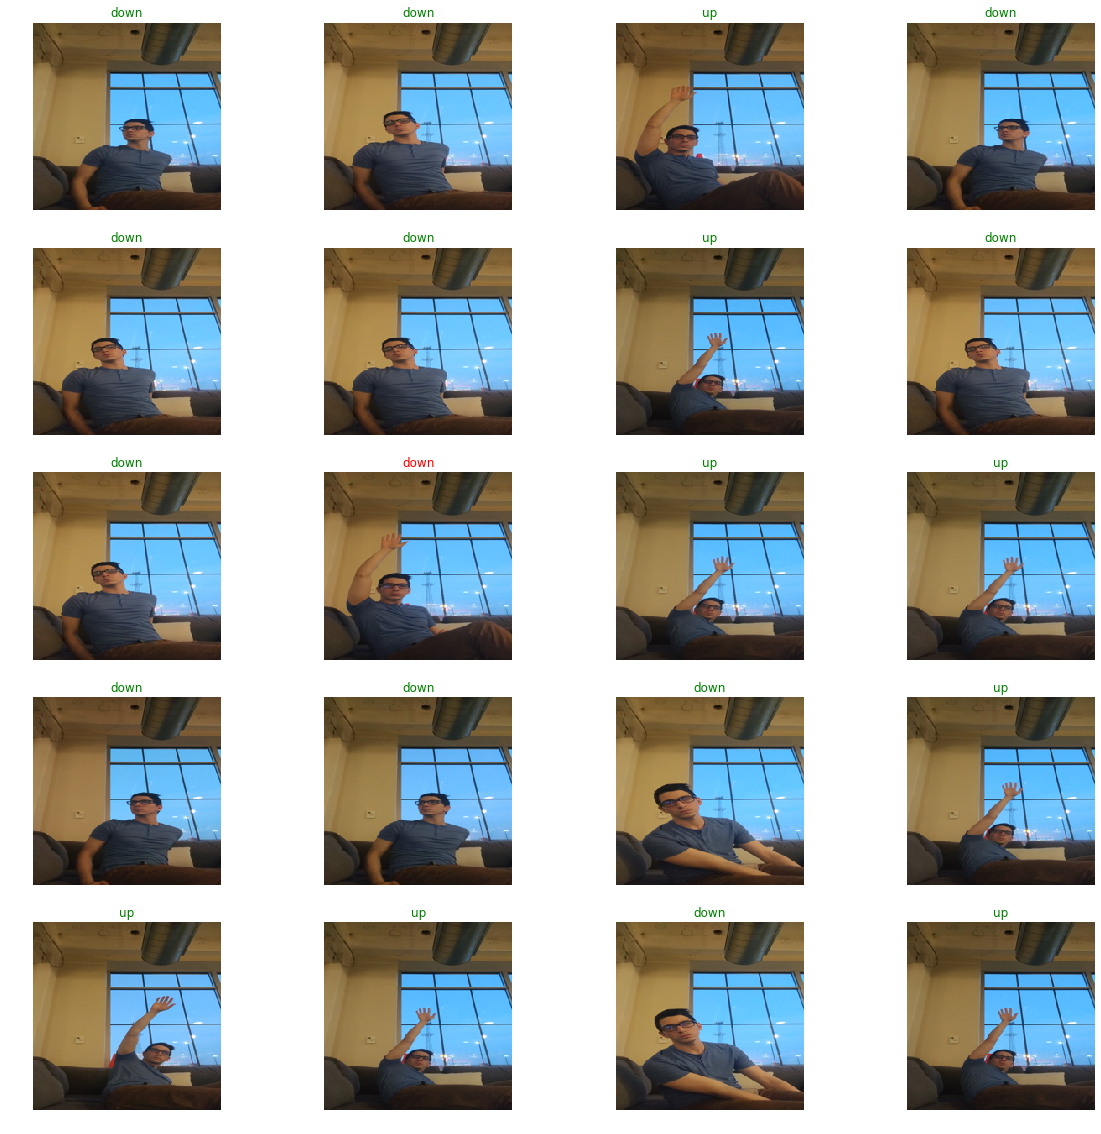

In [18]:
# Test the model with some images
for image_batch, label_batch in test_data:
  break

pred_batch = model.predict(image_batch)
pred_batch = np.argmax(pred_batch, axis=-1)
label_batch = np.argmax(label_batch, axis=-1)

rev_index = dict([(v, k) for (k, v) in train_data.class_indices.items()])
plt.figure(figsize=(20,20))
for i in range(20):
  plt.subplot(5, 4, i+1)
  plt.imshow(image_batch[i])
  title = rev_index[pred_batch[i]]
  color = 'green' if label_batch[i] == pred_batch[i] else 'red'
  plt.title(title, color=color)
  plt.axis('off')